In [2]:
import pandas
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
input_shape = (224, 224)
categories_num = 37
batch_size = 32

Создадим генератор для обучения автокодировщика. Возьмем только 1/3 часть нашей тренировочной базы. 

In [4]:
train_data = pandas.read_csv('../train_pets.csv', usecols=['Category', 'Path']).iloc[::3]
val_data = pandas.read_csv('../val_pets.csv', usecols=['Category', 'Path']).iloc[::3]

train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='.',
        x_col='Path',
        class_mode='input',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        class_mode='input',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 2145 validated image filenames.
Found 111 validated image filenames.


In [5]:
def plot_history(histories, save=False, folder=""):
    # Plot training & validation accuracy values
    plt.figure(1)
    for i in range(len(histories)):
        plt.plot(histories[i].history['categorical_accuracy'])
        plt.plot(histories[i].history['val_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.figure(2)
    for i in range(len(histories)):
        plt.plot(histories[i].history['loss'])
        plt.plot(histories[i].history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

Возьмем метод для генерации модели из предыдущей работы. Добавим в модель декодировщик.

In [7]:
from keras import Sequential
from keras.layers import *
from keras.optimizers import Adam

model_1 = Sequential()
image_inputs = Input(shape=(input_shape[0], input_shape[1], 3,))
    
model_1.add(Conv2D(64, (7, 7), padding='same',
                     input_shape=(input_shape[0], input_shape[1], 3,)))
model_1.add(BatchNormalization())
model_1.add(ReLU())
    
model_1.add(MaxPooling2D((2, 2)))

model_1.add(Conv2D(64, (7, 7), padding="same", name='up'))
model_1.add(BatchNormalization())
model_1.add(ReLU())

model_1.add(UpSampling2D(size=(2, 2)))

model_1.add(Conv2D(3, (3, 3), padding="same", activation='sigmoid'))
        
model_1.compile(optimizer=Adam(), loss='mse')
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      9472      
_________________________________________________________________
batch_normalization_3 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
up (Conv2D)                  (None, 112, 112, 64)      200768    
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 112, 112, 64)      0         
__________

In [8]:
history_1 = model_1.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=30,
            verbose=1,
            callbacks=[EarlyStopping(patience=10)])

Epoch 1/30
67/67 [==============================] - 18s 273ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 2/30
67/67 [==============================] - 14s 216ms/step - loss: 0.0050 - val_loss: 0.0072
Epoch 3/30
67/67 [==============================] - 14s 213ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 4/30
67/67 [==============================] - 14s 215ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 5/30
67/67 [==============================] - 14s 213ms/step - loss: 0.0046 - val_loss: 0.0059
Epoch 6/30
67/67 [==============================] - 14s 213ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 7/30
67/67 [==============================] - 14s 212ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 8/30
67/67 [==============================] - 14s 213ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 9/30
67/67 [==============================] - 14s 214ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/30
67/67 [==============================] - 14s 214ms/step - loss: 0.0032 - val_lo

KeyError: 'categorical_accuracy'

<Figure size 432x288 with 0 Axes>

In [26]:
model_2 = Sequential()

for l in model_1.layers:
    if l.name is 'up':
        break
    l.trainable = False
    model_2.add(l)

model_2.add(Conv2D(128, (3, 3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(ReLU())
model_2.add(Conv2D(128, (3, 3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(ReLU())

model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(128, (3, 3), padding="same", name='up'))
model_2.add(BatchNormalization())
model_2.add(ReLU())
model_2.add(Conv2D(128, (3, 3), padding="same"))
model_2.add(BatchNormalization())
model_2.add(ReLU())

model_2.add(UpSampling2D(size=(2, 2)))

model_2.add(Conv2D(64, (7, 7), padding="same"))
model_2.add(BatchNormalization())
model_2.add(ReLU())
        
model_2.add(UpSampling2D(size=(2, 2)))
    
model_2.add(Conv2D(3, (3, 3), padding="same", activation='sigmoid'))
        
model_2.compile(optimizer=Adam(), loss='mse')
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      9472      
_________________________________________________________________
batch_normalization_3 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_55 (Batc (None, 112, 112, 128)     512       
_________________________________________________________________
re_lu_55 (ReLU)              (None, 112, 112, 128)     0         
__________

In [27]:
history_2 = model_2.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=30,
            verbose=1,
            callbacks=[EarlyStopping(patience=10)])

Epoch 1/30
67/67 [==============================] - 34s 505ms/step - loss: 0.0118 - val_loss: 0.0134
Epoch 2/30
67/67 [==============================] - 34s 513ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 3/30
67/67 [==============================] - 35s 518ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 4/30
67/67 [==============================] - 35s 526ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 5/30
67/67 [==============================] - 35s 524ms/step - loss: 0.0055 - val_loss: 0.0066
Epoch 6/30
67/67 [==============================] - 35s 527ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 7/30
67/67 [==============================] - 35s 524ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 8/30
67/67 [==============================] - 35s 529ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 9/30
67/67 [==============================] - 35s 525ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 10/30
67/67 [==============================] - 35s 524ms/step - loss: 0.0046 - val_lo

In [28]:
model_3 = Sequential()

for l in model_2.layers:
    if l.name is 'up':
        break
    l.trainable = False
    model_3.add(l)

model_3.add(Conv2D(256, (3, 3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(ReLU())
model_3.add(Conv2D(256, (3, 3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(ReLU())

model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(256, (3, 3), padding="same", name='up'))
model_3.add(BatchNormalization())
model_3.add(ReLU())
model_3.add(Conv2D(256, (3, 3), padding="same"))
model_3.add(BatchNormalization())
model_3.add(ReLU())

model_3.add(UpSampling2D(size=(2, 2)))

model_3.add(Conv2D(128, (3, 3), padding="same"))
model_3.add(BatchNormalization())
model_3.add(ReLU())
model_3.add(Conv2D(128, (3, 3), padding="same"))
model_3.add(BatchNormalization())
model_3.add(ReLU())

model_3.add(UpSampling2D(size=(2, 2)))

model_3.add(Conv2D(64, (7, 7), padding="same"))
model_3.add(BatchNormalization())
model_3.add(ReLU())
        
model_3.add(UpSampling2D(size=(2, 2)))

model_3.add(Conv2D(3, (3, 3), padding="same", activation='sigmoid'))
        
model_3.compile(optimizer=Adam(), loss='mse')
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      9472      
_________________________________________________________________
batch_normalization_3 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_55 (Batc (None, 112, 112, 128)     512       
_________________________________________________________________
re_lu_55 (ReLU)              (None, 112, 112, 128)     0         
__________

In [29]:
history = model_3.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=30,
            verbose=1,
            callbacks=[EarlyStopping(patience=10)])

Epoch 1/30
67/67 [==============================] - 37s 557ms/step - loss: 0.0204 - val_loss: 0.0154
Epoch 2/30
67/67 [==============================] - 37s 552ms/step - loss: 0.0112 - val_loss: 0.0123
Epoch 3/30
67/67 [==============================] - 37s 549ms/step - loss: 0.0093 - val_loss: 0.0125
Epoch 4/30
67/67 [==============================] - 37s 550ms/step - loss: 0.0085 - val_loss: 0.0089
Epoch 5/30
67/67 [==============================] - 37s 553ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 6/30
67/67 [==============================] - 37s 550ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 7/30
67/67 [==============================] - 37s 551ms/step - loss: 0.0066 - val_loss: 0.0084
Epoch 8/30
67/67 [==============================] - 37s 549ms/step - loss: 0.0077 - val_loss: 0.0091
Epoch 9/30
67/67 [==============================] - 37s 553ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 10/30
67/67 [==============================] - 37s 557ms/step - loss: 0.0065 - val_lo

In [30]:
model_3.save('conv_auto.h5')

In [31]:
test_data = pandas.read_csv('../test_pets.csv', usecols=['Category', 'Path'])
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='.',
        x_col='Path',
        class_mode='input',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 333 validated image filenames.


In [32]:
history_1 = model_3.evaluate_generator(
    test_generator,
    steps=test_generator.n // batch_size,
    verbose=1)

print(f'test loss: {history_1}')

10/10 [==============================] - 2s 211ms/step
test loss: 0.005554840713739395


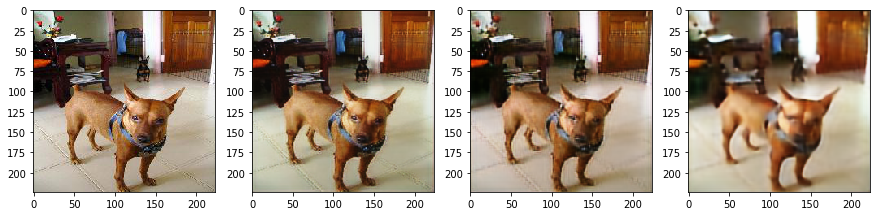

In [34]:
sample = test_generator.next()
image_array = sample[0]

predictions_1 = model_1.predict(image_array)[0]
predictions_2 = model_2.predict(image_array)[0]
predictions_3 = model_3.predict(image_array)[0]

fig, axes = plt.subplots(1, 4)
fig.set_figwidth(15)
fig.set_figheight(10)

axes[0].imshow(image_array[0])
axes[1].imshow(predictions_1)
axes[2].imshow(predictions_2)
axes[3].imshow(predictions_3)

plt.show()

Как видно автокодировщик попытался выделить на изображении главные части, которые могут повлиять на дальнейшую классификацию.

Уберем из модели часть декодера и вставим наш классификатор из предыдущей работы.

In [43]:
from keras.metrics import categorical_accuracy

def build_model(auto_model, lr=0.001):
    model = Sequential()
    
    for layer in auto_model.layers:
        if 'up' in layer.name:
            break
        layer.trainable = True
        model.add(layer)
        
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.7))
    
    model.add(Dense(units=categories_num, activation='softmax'))
    
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=[categorical_accuracy])
    
    return model

In [44]:
conv_model = build_model(model_3)
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      9472      
_________________________________________________________________
batch_normalization_3 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_55 (Batc (None, 112, 112, 128)     512       
_________________________________________________________________
re_lu_55 (ReLU)              (None, 112, 112, 128)     0         
__________

Обучим получившуюся модель с проинициализированными весами. При этом будем применять аугментацию данных.

In [45]:
train_data = pandas.read_csv('../train_pets.csv', usecols=['Category', 'Path'])
val_data = pandas.read_csv('../val_pets.csv', usecols=['Category', 'Path'])

train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=10,
        zoom_range=0.1,
        brightness_range=(0.7, 1.3),
        horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 6434 validated image filenames belonging to 37 classes.
Found 333 validated image filenames belonging to 37 classes.


In [ ]:
history_2 = conv_model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
            callbacks=[EarlyStopping(patience=10)])

plot_history([history_2])

Ошибка и точность модели никак не изменились. Но изменилось колучиство эпох для достижения таких же результатов. 34 эпохи против 66 в предыдущей работе.

Попробуем так же уменьшить learnnig rate в надежде на большую сходимость к минимуму.

In [55]:
conv_model.optimizer = Adam(lr=0.0003)

Epoch 1/10
 - 20s - loss: 0.8651 - categorical_accuracy: 0.7295 - val_loss: 1.8050 - val_categorical_accuracy: 0.4917
Epoch 2/10
 - 18s - loss: 0.8592 - categorical_accuracy: 0.7295 - val_loss: 1.3097 - val_categorical_accuracy: 0.5880
Epoch 3/10
 - 18s - loss: 0.8220 - categorical_accuracy: 0.7435 - val_loss: 2.2061 - val_categorical_accuracy: 0.4551
Epoch 4/10
 - 17s - loss: 0.8181 - categorical_accuracy: 0.7426 - val_loss: 1.3140 - val_categorical_accuracy: 0.5914
Epoch 5/10
 - 17s - loss: 0.7739 - categorical_accuracy: 0.7620 - val_loss: 1.4386 - val_categorical_accuracy: 0.5847
Epoch 6/10
 - 17s - loss: 0.7962 - categorical_accuracy: 0.7494 - val_loss: 1.5383 - val_categorical_accuracy: 0.5781
Epoch 7/10
 - 17s - loss: 0.6980 - categorical_accuracy: 0.7803 - val_loss: 1.3654 - val_categorical_accuracy: 0.5875
Epoch 8/10
 - 17s - loss: 0.7642 - categorical_accuracy: 0.7643 - val_loss: 1.2671 - val_categorical_accuracy: 0.5947
Epoch 9/10
 - 17s - loss: 0.7216 - categorical_accuracy:

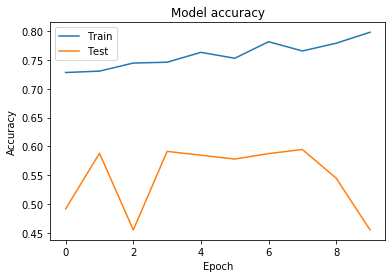

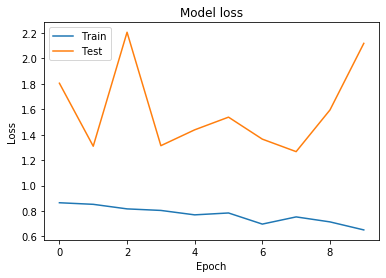

In [56]:
early_stop = EarlyStopping(patience=10)

history_2 = conv_model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_2])

Опять же совершенно аналогичные результаты, за исключением количества эпох.

Получились неплохие результаты с учетом того, что время на обучение модели потребовалось в 2 раза меньше. К увеличению точности, к сожалению, это не привело.

In [58]:
conv_model.save('conv+auto+augdata.h5')

### Тестирование

In [62]:
best_model_1 = load_model('conv+auto+augdata.h5')

In [63]:
test_data = pandas.read_csv('../test_pets.csv', usecols=['Category', 'Path'])
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 333 validated image filenames belonging to 37 classes.


In [76]:
history_1 = best_model_1.evaluate_generator(
    test_generator,
    steps=test_generator.n // batch_size,
    verbose=1)

print(f' - test loss: {history_1[0]}, test accuracy: {history_1[1]}')

10/10 [==============================] - 1s 68ms/step
 - test loss: 1.2430409238584017, test accuracy: 0.6544850508239974


Original: Bombay
 - Bombay 0.99999905
 - scottish_terrier 9.241556e-07
 - Siamese 1.5148202e-09


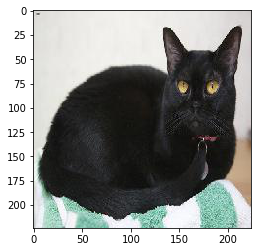

In [86]:
sample = test_generator.next()
image_array = sample[0]
categories_dict = {value: key for key, value in test_generator.class_indices.items()}
category = categories_dict[np.argmax(sample[1][0])]

predictions_1 = best_model_1.predict(image_array)[0]

best_args_1 = np.argsort(predictions_1)[::-1][:3]

print(f'Original: {category}')
for i in best_args_1:
    print(' -', categories_dict[i], predictions_1[i])

plt.imshow(image_array[0])